In [1]:
import os
from os.path import join
import numpy as np
import cv2
import matplotlib.pyplot as plt
from side_extractor import process_piece, plot_side_images
from functools import partial
import traceback

In [2]:
filenames = os.listdir('images')
filenames.sort()

In [3]:
def plot_grid(size, out_dict, *image_keys):
    h, w = size
    for idx, img_key in enumerate(image_keys, start=1):
        plt.subplot(h * 100 + w * 10 + idx)
        if img_key[0] == '_':
            plt.imshow(out_dict[img_key[1:]], cmap='gray')
        else:
            plt.imshow(out_dict[img_key])

In [4]:
label_tuples = [('A', 74), ('B', 43), ('C', 19), ('D', 72), ('E', 11)]

def create_label(label_tuple):
    letter, max_num = label_tuple
    for i in range(1, max_num + 1):
        label = letter + str(i) if i >= 10 else letter + '0' + str(i)
        yield label
        
labels = []
for label_tuple in label_tuples:
    for label in create_label(label_tuple):
        labels.append(label)

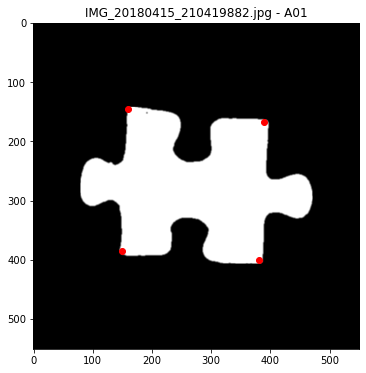

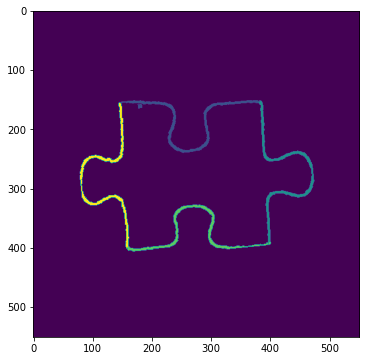

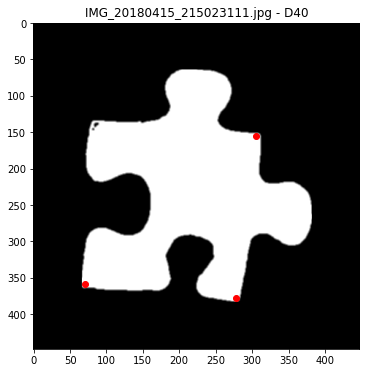

D40 : Not enough corners


NoneType: None


In [5]:
postprocess = partial(cv2.blur, ksize=(3, 3))
results = []
error_labels = []

for filename, label in zip(filenames, labels):
    img = cv2.imread(join('images', filename))
    img = img[1750:2500, 1000:2000]
    
    out_dict = process_piece(img, after_segmentation_func=postprocess, scale_factor=0.4, 
                             harris_block_size=5, harris_ksize=5,
                             corner_score_threshold=0.2, corner_minmax_threshold=100)
    
    plot_image = len(results) == 0 or 'error' in out_dict
    if plot_image:
        plt.figure(figsize=(6, 6))
        plt.title("{0} - {1}".format(filename, label))
        plt.imshow(out_dict['extracted'], cmap='gray')
        plt.scatter(out_dict['xy'][:, 0], out_dict['xy'][:, 1], color='red')
        #plt.colorbar()
        plt.show()
    
    if 'error' in out_dict:
        print(label, ':', out_dict['error'])
        error_labels.append(label)
        traceback.print_exc()
        continue
        
    if plot_image:
        
        plt.figure(figsize=(6, 6))
        # plt.title("{0} - {1}".format(filename, label))
        plt.imshow(out_dict['class_image'])
        #plot_grid((3, 3), out_dict, '_segmented', '_extracted', '_edges', 'class_image')
        plt.show()

        # plot_side_images(out_dict['side_images'], out_dict['inout'])

    results.append({'label': label, 'filename': filename, 'source':out_dict['source'],'harris':out_dict['harris'], 'segmented':out_dict['segmented'], 'extracted':out_dict['extracted'], 'class_image':out_dict['class_image'], 'side_images': out_dict['side_images'], 'inout': out_dict['inout']})

In [6]:
for result in results:
    
    label = result['label']

    out_path = join('sides', label + '_source.jpg')
    cv2.imwrite(out_path, result['source'])
    
    out_path = join('sides', label + '_segment.png')
    cv2.imwrite(out_path, result['segmented'])
    
    out_path = join('sides', label + '_extract.png')
    cv2.imwrite(out_path, result['extracted'])

    out_path = join('sides', label + '_harris.png')
    cv2.imwrite(out_path, result['harris'])
    
    out_path = join('sides', label + '_class.png')
    cv2.imwrite(out_path, result['class_image']*255)
    
    for i, (side_image, io) in enumerate(zip(result['side_images'], result['inout']), start=1):
        
        out_io = 'int' if io == 'in' else 'out'
        side_image = side_image * 255
        
        out_filename = "{0}_{1}_{2}.png".format(label, i, out_io)
        out_path = join('sides', out_filename)
        
        cv2.imwrite(out_path, side_image)